In [12]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.classify(z, training=training)
        y_pred = self.classifier( self.decode(z ,training=training) )
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
#     def classify(self, z, training=True):
#         return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
#             Input(shape=(latent_dim)),
            Input(shape=(28,28,1)),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(50, activation='relu'),
            Dense(10, activation='softmax')
        ])

In [13]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 4, 14, 14, 1)


Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3025 - acc: 0.9128 - val_loss: 0.1956 - val_acc: 0.9426
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1613 - acc: 0.9518 - val_loss: 0.1478 - val_acc: 0.9581
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1322 - acc: 0.9585 - val_loss: 0.1424 - val_acc: 0.9570
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1150 - acc: 0.9635 - val_loss: 0.1295 - val_acc: 0.9625
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1032 - acc: 0.9681 - val_loss: 0.1240 - val_acc: 0.9642
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0941 - acc: 0.9707 - val_loss: 0.1292 - val_acc: 0.9613
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0856 - acc: 0.9733 - val_loss: 0.1290 - val_acc: 0.9640
Epoch 8/10
1875/1875 [==============================] - 5s 3ms

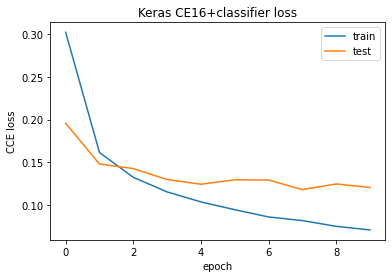

In [14]:
# model.encoder.load_weights('../weights/19_CE16_epoch25.h5')
model.encoder.load_weights('../weights/18_CE4_ordered_epoch25.h5')
model.decoder.load_weights('../weights/20_CD4_epoch25.h5')
for layer in model.encoder.layers:
    layer.trainable = False
for layer in model.decoder.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# model.decoder.save_weights('../weights/20_CD4_epoch25.h5')

In [15]:
import keras
import numpy as np

n_splits = 1
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model2 = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)
print(x_test_split.shape)

(10000, 1, 28, 28, 1)


Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2803 - acc: 0.9199 - val_loss: 0.1971 - val_acc: 0.9412
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1370 - acc: 0.9590 - val_loss: 0.1396 - val_acc: 0.9573
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1091 - acc: 0.9676 - val_loss: 0.1333 - val_acc: 0.9607
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0927 - acc: 0.9711 - val_loss: 0.1182 - val_acc: 0.9662
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0809 - acc: 0.9750 - val_loss: 0.1109 - val_acc: 0.9675
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0730 - acc: 0.9769 - val_loss: 0.1180 - val_acc: 0.9685
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0647 - acc: 0.9788 - val_loss: 0.1096 - val_acc: 0.9684
Epoch 8/10
1875/1875 [==============================] - 5s 3ms

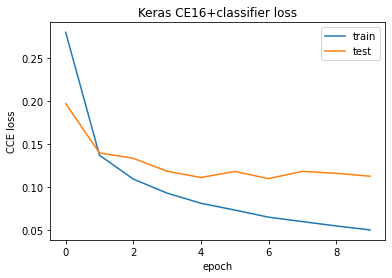

In [16]:
# model.encoder.load_weights('../weights/19_CE16_epoch25.h5')
model2.encoder.load_weights('../weights/19_CE16_epoch25.h5')
model2.decoder.load_weights('../weights/20_CD16_epoch25.h5')
for layer in model2.encoder.layers:
    layer.trainable = False
for layer in model2.decoder.layers:
    layer.trainable = False
    
model2.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = model2.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# model.decoder.save_weights('../weights/20_CD4_epoch25.h5')